# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [57]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [97]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point" # "3-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 20 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.2

# Mock cycle/two-level cycle nu value list.
nu_values = np.arange(1, 12)

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513016


## Level 0->1 Coarsening

In [98]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)

# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

# Save null-space vectors so we dan orthogonalize error vectors to them.
num_eigenvectors = 10
z, lam = hm.analysis.ideal.ideal_tv(level.a, num_eigenvectors)
ind = (np.abs(lam[:num_eigenvectors]) < 1e-6)
z = z[:, ind]
z = hm.linalg.gram_schmidt(z)

### Relaxation


INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.257e+00                    4.469e-01    2.814
INFO     1     6.900e-01 (0.549) [0.549]    3.494e-01    1.986 (0.704)
INFO     2     4.074e-01 (0.591) [0.570]    3.044e-01    1.351 (0.679)
INFO     3     2.584e-01 (0.635) [0.591]    2.807e-01    0.932 (0.689)
INFO     4     1.811e-01 (0.702) [0.617]    2.663e-01    0.689 (0.740)
INFO     5     1.381e-01 (0.763) [0.644]    2.563e-01    0.545 (0.793)
INFO     6     1.138e-01 (0.823) [0.671]    2.486e-01    0.463 (0.849)
INFO     7     9.861e-02 (0.865) [0.696]    2.423e-01    0.411 (0.888)
INFO     8     8.822e-02 (0.894) [0.718]    2.368e-01    0.375 (0.914)
INFO     9     8.062e-02 (0.913) [0.738]    2.321e-01    0.350 (0.932)
INFO     10    7.472e-02 (0.926) [0.755]    2.278e-01    0.330 (0.944)
INFO     11    6.996e-02 (0.936) [0.770]    2.239e-01    0.314 (0.952)
INFO     12    6.601e-02 (0.943) [0.783]    2.204e-01    0.301 (0.959)
INFO 

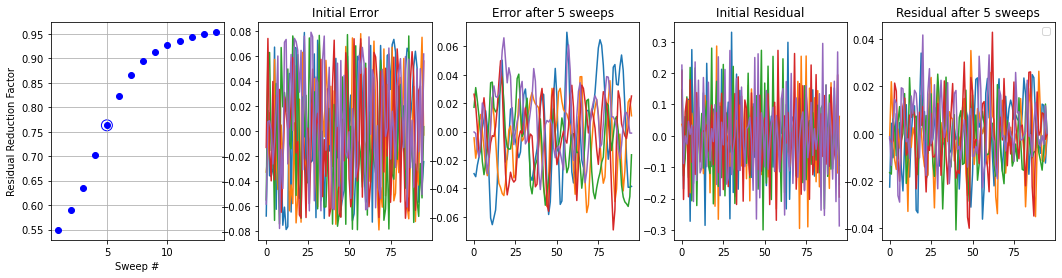

In [100]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

### Coarsening: Fixed (4/2)

In [61]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = -1

all_conv, r, p, q = helmholtz.analysis.stats.compare_coarsening(level, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       calibers=(2, 3, 4), ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_values=nu_values,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 4 TVs with 20 sweeps
INFO     RER 0.207


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.5905,0.3206,0.1956,0.1501,0.1473,0.1310,0.0871,0.0700,0.0670,0.0632,0.0609
P^T A P caliber 2,1.2000,0.0000,0.5458,0.3822,0.4840,0.5007,0.4405,0.4328,0.4317,0.4254,0.4096,0.4060,0.3980
P^T A P caliber 3,1.4000,0.0000,0.5904,0.3562,0.3000,0.3428,0.2946,0.2695,0.2845,0.2807,0.2675,0.2633,0.2556
P^T A P caliber 4,2.0000,0.0000,0.6058,0.3124,0.1851,0.1277,0.1396,0.1365,0.1039,0.0625,0.0527,0.0487,0.0442
R A P caliber 4,1.2000,0.0045,20.0653,2.2458,5.6062,1.3789,1.5791,0.6688,0.4906,0.2032,0.1087,0.0956,0.0620
Q A P caliber 4,1.2000,0.0000,5.5853,0.6381,1.5859,0.3981,0.4473,0.1719,0.1160,0.0870,0.0510,0.0402,0.0340


## Symmetrizing $R A P$ into $Q A P$

### Slowest Component, RER reduction
All measurements (RER, plot of errors) are performed after removing the null components after each cycle. Cycles are $(0, \nu)$, so the error is measured after relaxations.

In [62]:
def run_r_vs_q(nu, nu_coarsest):
    titles = ("r", "q")
    restrictions = (r, q)
    fig, axs = plt.subplots(1, len(titles), figsize=(12, 4))

    for title, restriction, ax in zip(titles, restrictions, axs):
        print("Restriction", title)
        ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
            level.a, level.location, r, p, restriction, aggregate_size, num_components)
        y, _ = hm.repetitive.locality.two_level_conv_factor(
                    ml, nu_pre=0, nu_post=nu, nu_coarsest=nu_coarsest, print_frequency=1, z=z, seed=0, num_sweeps=20, debug=False, num_levels=2)
        #y -= z.dot(z.T.dot(y[:, None])).flatten()

        # Asymptotic vector.
        ax.set_title("Slowest Vector in Two-level Cycle(0, {})".format(nu))
        e = ml[1].interpolate(r.dot(y))
        ax.plot(y, label="x");
        ax.plot(e, label="PRx");
        ax.grid(True);
        ax.legend();

#### Two-level Cycle with exact coarse level solve

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.087e+01           2.468           8.455
INFO     1      5.983e+00  (0.287)  1.050  (0.426)  5.697
INFO     2      8.429e+00  (1.409)  1.873  (1.784)  4.500
INFO     3      1.263e+01  (1.498)  1.769  (0.945)  7.139
INFO     4      2.080e+01  (1.647)  1.878  (1.061)  11.075
INFO     5      3.167e+01  (1.523)  1.780  (0.948)  17.793
INFO     6      5.128e+01  (1.619)  1.865  (1.047)  27.503
INFO     7      7.959e+01  (1.552)  1.797  (0.964)  44.297
INFO     8      1.262e+02  (1.586)  1.845  (1.027)  68.401
INFO     9      2.001e+02  (1.585)  1.817  (0.985)  110.114
INFO     10     3.106e+02  (1.552)  1.823  (1.003)  170.378
INFO     11     5.027e+02  (1.618)  1.839  (1.009)  273.336
INFO     12     7.654e+02  (1.523)  1.801  (0.979)  424.951
INFO     13     1.260e+03  (1.646)  1.859  (1.032)  677.732
INFO     14     1.891e+03  (1.501)  1.783  (0.959)  1060.873
INFO     15     3.147e+03  (1.664)  1.8

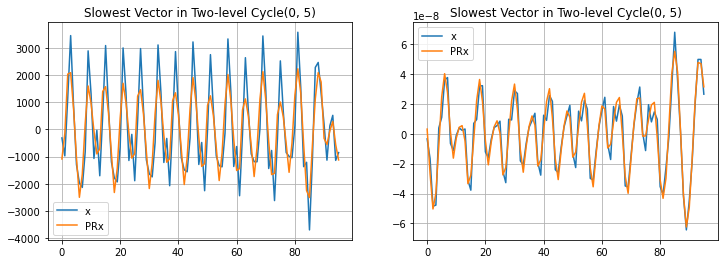

In [63]:
run_r_vs_q(5, -1)

#### Two-level Cycle with many relaxations at coarse level

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.087e+01           2.468           8.455
INFO     1      3.162e+00  (0.152)  0.626  (0.254)  5.053
INFO     2      3.338e-01  (0.106)  0.587  (0.937)  0.569
INFO     3      4.668e-02  (0.140)  0.618  (1.054)  0.075
INFO     4      8.568e-03  (0.184)  0.575  (0.930)  0.015
INFO     5      1.541e-03  (0.180)  0.591  (1.028)  0.003
INFO     6      3.006e-04  (0.195)  0.588  (0.995)  0.001
INFO     7      5.824e-05  (0.194)  0.594  (1.010)  0.000
INFO     8      1.144e-05  (0.196)  0.591  (0.994)  0.000
INFO     9      2.270e-06  (0.199)  0.595  (1.008)  0.000
INFO     10     4.658e-07  (0.205)  0.607  (1.020)  0.000
INFO     11     9.392e-08  (0.202)  0.594  (0.978)  0.000
INFO     12     1.852e-08  (0.197)  0.584  (0.984)  0.000
INFO     13     3.695e-09  (0.199)  0.588  (1.007)  0.000
INFO     14     7.382e-10  (0.200)  0.589  (1.001)  0.000
INFO     15     1.463e-10  (0.198)  0.584  (0.993)  0.000

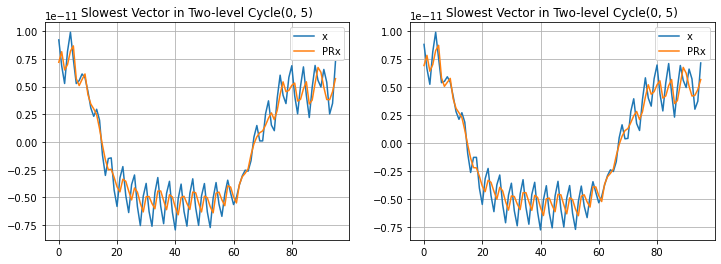

In [64]:
run_r_vs_q(5, 100)

#### Two-level Relaxation Mini-Cycle

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.087e+01           2.468           8.455
INFO     1      3.200e+00  (0.153)  0.663  (0.269)  4.829
INFO     2      4.158e-01  (0.130)  0.258  (0.389)  1.614
INFO     3      1.274e-01  (0.306)  0.113  (0.438)  1.130
INFO     4      8.793e-02  (0.690)  0.097  (0.860)  0.907
INFO     5      7.026e-02  (0.799)  0.095  (0.979)  0.740
INFO     6      5.697e-02  (0.811)  0.094  (0.988)  0.607
INFO     7      4.662e-02  (0.818)  0.093  (0.996)  0.499
INFO     8      3.824e-02  (0.820)  0.093  (0.998)  0.410
INFO     9      3.140e-02  (0.821)  0.093  (0.999)  0.337
INFO     10     2.579e-02  (0.821)  0.093  (0.999)  0.277
INFO     11     2.118e-02  (0.821)  0.093  (0.999)  0.228
INFO     12     1.739e-02  (0.821)  0.093  (0.999)  0.187
INFO     13     1.427e-02  (0.821)  0.093  (0.998)  0.154
INFO     14     1.171e-02  (0.821)  0.093  (0.998)  0.127
INFO     15     9.604e-03  (0.820)  0.092  (0.998)  0.104

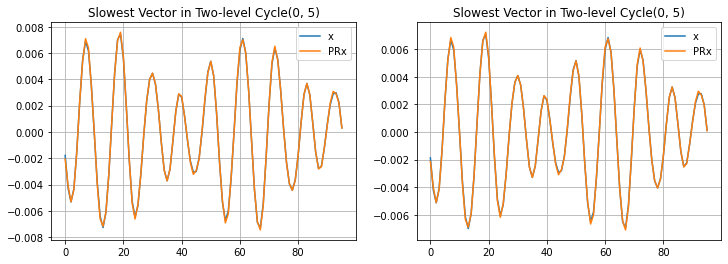

In [65]:
run_r_vs_q(5, 5)

#### Level 1 Relaxation Shrinkage

#### $P^T A P$

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     3.753e-01                    4.469e-01    0.842
INFO     1     1.587e-01 (0.433) [0.433]    3.034e-01    0.521 (0.634)
INFO     2     9.758e-02 (0.618) [0.514]    2.555e-01    0.381 (0.734)
INFO     3     5.672e-02 (0.597) [0.537]    2.364e-01    0.242 (0.645)
INFO     4     4.214e-02 (0.744) [0.583]    2.258e-01    0.188 (0.779)
INFO     5     3.524e-02 (0.838) [0.627]    2.181e-01    0.162 (0.867)
INFO     6     3.045e-02 (0.865) [0.661]    2.120e-01    0.144 (0.891)
INFO     7     2.723e-02 (0.895) [0.690]    2.069e-01    0.132 (0.918)
INFO     8     2.490e-02 (0.915) [0.715]    2.024e-01    0.124 (0.935)
INFO     9     2.312e-02 (0.928) [0.736]    1.985e-01    0.117 (0.947)
INFO     10    2.170e-02 (0.938) [0.754]    1.949e-01    0.112 (0.955)
INFO     11    2.051e-02 (0.944) [0.769]    1.917e-01    0.107 (0.960)
INFO     12    1.948e-02 (0.949) [0.783]    1.888e-01    0.103 (0.964)
INFO 

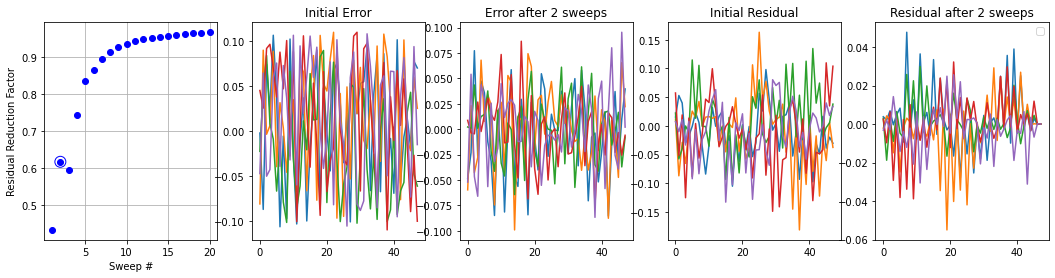

In [103]:
m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, p.T, aggregate_size, num_components)
m1 = m0.sub_hierarchy(1)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

#### $Q A P$

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.816e-01                    4.471e-01    0.630
INFO     1     1.015e-01 (0.363) [0.363]    2.687e-01    0.379 (0.606)
INFO     2     5.303e-02 (0.534) [0.435]    2.087e-01    0.256 (0.686)
INFO     3     3.081e-02 (0.580) [0.479]    1.875e-01    0.165 (0.646)
INFO     4     2.296e-02 (0.745) [0.535]    1.754e-01    0.132 (0.797)
INFO     5     1.861e-02 (0.810) [0.581]    1.672e-01    0.112 (0.851)
INFO     6     1.603e-02 (0.861) [0.620]    1.610e-01    0.100 (0.895)
INFO     7     1.434e-02 (0.896) [0.654]    1.560e-01    0.093 (0.925)
INFO     8     1.313e-02 (0.917) [0.682]    1.517e-01    0.088 (0.944)
INFO     9     1.220e-02 (0.930) [0.706]    1.479e-01    0.084 (0.955)
INFO     10    1.143e-02 (0.938) [0.726]    1.445e-01    0.081 (0.961)
INFO     11    1.078e-02 (0.943) [0.743]    1.414e-01    0.078 (0.965)
INFO     12    1.021e-02 (0.947) [0.758]    1.385e-01    0.076 (0.968)
INFO 

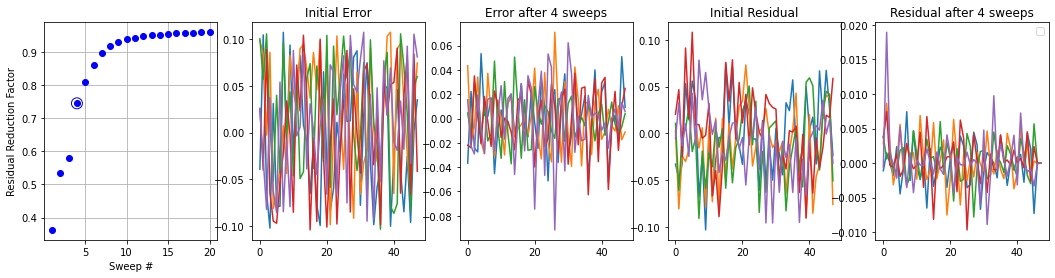

In [84]:
m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, q, aggregate_size, num_components)
m1 = m0.sub_hierarchy(1)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

### Conclusions
* It is important to not exactly solve at the coarse level especially when null/near-null space components are present, in order to avoid inflating them due to round-off errors.
* $Q A P$ is as good as $R A P$ for different seeds.
* A two-level cycle (with many relaxations at the coarse level) does not reduce the RER more than relaxation. That's OK: again, many relaxations at the coarse level will affeect very smooth components and thus their aliasing.
* To see good shrinkage, use a relaxation mini-cycle (only several relaxations at the coarse level). Note that we only need one relaxation at the coarse level to get a good RER reduction (and indeed, Kaczmarz is a good smoother at level 1).

## Equation Interpretability
We (maybe) expect the coarse equations to be $U x_{i-1} + x_i + U^T x_{i+1}$ where $U$ is a rotation whose angle depends on $kh$.

In [67]:
# Normalized level 0 equations.
level.a.todense()[2, :5] / level.a.todense()[2,2]

matrix([[ 0.037, -0.599,  1.   , -0.599,  0.037]])

In [68]:
print("R")
display(pd.DataFrame(r[:2, :4].todense()))
print("Q")
display(pd.DataFrame(q[:2, :4].todense()))
print("P")
display(pd.DataFrame(ml[1]._p[6:10, 2:6].todense()))
print("RAP")
display(pd.DataFrame(r.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense()))
print("QAP")
qap = q.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense()
display(pd.DataFrame(qap))

R


,0,1,2,3
0,0.4377,0.5501,0.5527,0.4476
1,0.6723,0.2513,-0.2593,-0.6462


Q


,0,1,2,3
0,0.4390,0.5543,0.5552,0.4469
1,0.6619,0.2519,-0.2447,-0.6559


P


,0,1,2,3
0,-0.5935,-0.4071,0.0798,-0.1167
1,-0.3800,-0.4372,-0.1068,0.1734
2,-0.1042,-0.1681,-0.3804,0.4449
3,0.0796,0.1163,-0.5932,0.4067


RAP


,0,1,2,3,4,5
0,-0.1481,-0.1652,0.0320,0.0044,-0.1497,0.1695
1,-0.1770,-0.1631,-0.0033,-0.6494,0.1727,-0.1653


QAP


,0,1,2,3,4,5
0,-0.1492,-0.1667,0.0324,0.0027,-0.1499,0.1699
1,-0.1742,-0.1606,-0.0015,-0.6374,0.1698,-0.1591


In [69]:
d = qap[:, 2:4]
u = qap[:, :2]
l, v = eig(d)
#l = np.diag(np.abs(np.real(lam))**(-0.5))
#v = v.dot(l)
U = v.T.dot(u).dot(v)

In [70]:
# Off-diagonal U in U*x_{i-1} + x_i + U^T*x_{i+1} at level 1. x_i is a 2-species vector.
print("D", v.T.dot(d).dot(v))
print("U", U)

D [[ 0.032  0.004]
 [-0.    -0.637]]
U [[-0.148 -0.166]
 [-0.173 -0.159]]


In [71]:
# U = V^{-1}*D*V
D, V = eig(U)
print(V, D)

[[ 0.711  0.688]
 [-0.704  0.726]] [ 0.016+0.j -0.323+0.j]


* The original diagonal block is already nearly diagonal.
* $U$ is nearly but not exactly anti-symmetric, as is the corresponding block before diagonalizing the central block.
What does it mean? Will it become symmetric in the limit of many coarsening levels?
* $U$ has real eigenvalues. In quantum mehcanics it's called "PT-symmetric" (space-time-reversible system). cf. https://math.stackexchange.com/questions/746223/besides-being-symmetric-when-will-a-matrix-have-only-real-eigenvalues, 
https://arxiv.org/pdf/1212.1861.pdf . This happens iff there exists a self-adjoint (symmetric positive definite here) $W$ such that $W U = U^* W$.

In [72]:
# Example of an SPD matrix that commutes with U. Any w in the range where (b - c*w)^2 < (d-a)^2 w works. We take w = b/c, 
# which means W is nothing but a diagonal scaling of U...
#w = U[0, 1] / U[1, 0]
#w12 = (U[0, 1] - U[1, 0] * w) / (U[1, 1] - U[0, 0])
#W = np.array([[1, w12], [w12, w]])
W = np.diag(np.sign(np.real(l))).dot(np.array([[1, 0], [0, np.abs(U[0, 1] / U[1, 0])]]))
#W = np.array([[1, 0], [0, np.abs(U[0, 1] / U[1, 0])]])

In [73]:
print("W", W, "W U", W.dot(U), "U^* T", U.T.dot(W), "diff", W.dot(U) - U.T.dot(W))

W [[ 1.     0.   ]
 [ 0.    -0.957]] W U [[-0.148 -0.166]
 [ 0.166  0.152]] U^* T [[-0.148  0.166]
 [-0.166  0.152]] diff [[ 0.    -0.331]
 [ 0.331  0.   ]]


In [74]:
# After the full transformation - diagonalizing the central block and symmetrizing U:
print("D")
print(W.dot(v.T).dot(d).dot(v))
print("U") 
print(W.dot(v.T).dot(u).dot(v))

D
[[0.032 0.004]
 [0.    0.61 ]]
U
[[-0.148 -0.166]
 [ 0.166  0.152]]


So this is rather trivial - one can always make the central block symmetric. If it is positive definite, $U$ can be made anti-symmetric via diagonal scaling of the equations.

### Spectral Comparison

In [75]:
# Minimum eigenvalue of A is machine 0.
lam = np.real(eig(level.a.todense())[0])
lam0 = lam[np.argsort(np.abs(lam))][:30]
print(lam0)
print("min", lam0[0])

[-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167  0.205  0.205  0.235  0.235 -0.243 -0.243  0.257  0.257  0.27   0.27   0.274 -0.34  -0.34  -0.446 -0.446 -0.56  -0.56  -0.681]
min -4.30757792957478e-17


In [76]:
# Minimum eigenvalue of RAP is small but non-zero.
ac = r.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam1 = lam[np.argsort(np.abs(lam))][:30]
print(lam1)
print("min", lam1[0])

[-0.    -0.     0.137  0.137 -0.163 -0.163  0.242  0.242 -0.266 -0.267 -0.267 -0.27  -0.27  -0.275 -0.275 -0.282 -0.282 -0.292 -0.292 -0.293 -0.293 -0.299 -0.299 -0.304 -0.304  0.307  0.307 -0.312 -0.312 -0.317]
min -4.8339735935118997e-05


In [77]:
# Minimum eigenvalue of QAP is the same.
ac = q.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam2 = lam[np.argsort(np.abs(lam))][:30]
print(lam2)
print("min", lam2[0])

[ 0.     0.     0.139  0.139 -0.174 -0.174  0.243  0.243 -0.267 -0.268 -0.268 -0.271 -0.271 -0.272 -0.272 -0.278 -0.278 -0.288 -0.288 -0.296 -0.296 -0.3   -0.3   -0.305 -0.305 -0.306 -0.306 -0.306 -0.306  0.309]
min 0.00014848533005842545


In [78]:
# High order operator eigenvalue of P^T*A*P i sthe same.
ac = ml[1]._p.T.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam3 = lam[np.argsort(np.abs(lam))][:30]
print(lam3)
print("min", lam2[0])

[-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167  0.206  0.206  0.235  0.235 -0.242 -0.242  0.256  0.256  0.268  0.268  0.272 -0.321 -0.36  -0.448 -0.448 -0.561 -0.561 -0.683]
min 0.00014848533005842545


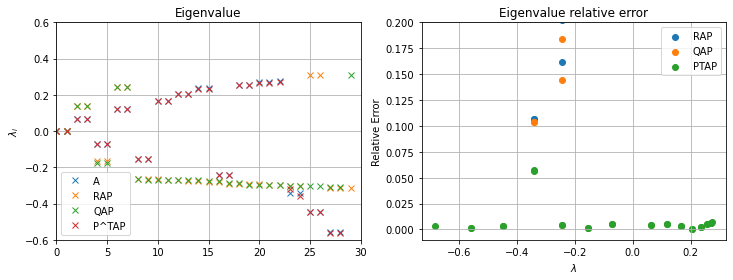

In [79]:
fig, axs = plt.subplots(1, len(titles), figsize=(12, 4))

ax = axs[0]
ax.plot(lam0, "x", label="A")
ax.plot(lam1, "x", label="RAP")
ax.plot(lam2, "x", label="QAP")
ax.plot(lam3, "x", label="P^TAP")
ax.grid(True);
ax.legend();
ax.set_xlim([0, 30]);
ax.set_ylim([-0.6, 0.6]);
ax.set_title("Eigenvalue");
ax.set_ylabel("$i$")
ax.set_ylabel("$\lambda_i$")

ax = axs[1]
ax.scatter(lam0, np.abs(lam1 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="RAP")
ax.scatter(lam0, np.abs(lam2 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="QAP")
ax.scatter(lam0, np.abs(lam3 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="PTAP")
ax.grid(True);
ax.legend();
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Relative Error")
ax.set_ylim([-0.01, 0.2]);
ax.set_title("Eigenvalue relative error");

Here we can clearly see that $QAP$ is a compromise between sparsity and accuracy: $P^T A P$ approximates many more eigenvalues accurately. It is unexpected that neither $P^T A P$ nor $R A P$ is exactly singular while $Q A P$ is (once again explaining while a direct coarse level solve is especially bad with $Q A P$).